<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/oilgasprocess1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install neqsim==2.5.35
#!pip install -U pydantic
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/reservoir/fluid1.e300

In [3]:
from pydantic import Field, field_validator
from pydantic.dataclasses import dataclass
from typing import Optional, List
from neqsim import jNeqSim
from functools import cache

@dataclass
class ProcessInput():
    """
    A class to define input parameters for the oil process.
    """
    moleRateHP: List[float] = Field(title="molar rates for 22 components to HP manifold [mol/sec]")
    moleRateLP: List[float] = Field(title="molar rates for 22 components to LP manifold [mol/sec]")
    firstStagePressure: float = Field(ge=0.0, le=100.0, title="Pressure of first stage separator [bara]")
    firstStageTemperature: float = Field(ge=0.0, le=100.0, title="Temperature of first stage separator [C]")
    secondStagePressure: float = Field(ge=0.0, le=100.0, title="Second stage separator pressure [bara]")
    secondStageTemperature: float = Field(ge=0.0, le=100.0, title="Second stage separator temperature [C]")
    thirdStagePressure: float = Field(ge=0.0, le=100.0, title="Third stage separator pressure [bara]")
    thirdStageTemperature: float = Field(ge=0.0, le=100.0, title="Third stage separator temperature [C]")
    export_oil_temperature: float = Field(ge=0.0, le=100.0, title="Export oil temperature [C]")
    export_oil_pressure: float = Field(ge=0.0, le=100.0, title="Export oil pressure [bara]")
    firstStageRecompressorPressure: float = Field(ge=0.0, le=100.0, title="First stage recompression pressure [bara]")
    dew_point_scrubber_temperature: float = Field(ge=0.0, le=100.0, title="Dew point scrubber temperature [C]")
    export_gas_pressure: float = Field(ge=0.0, le=200.0, title="Export gas pressure [bara]")
    export_gas_temperature: float = Field(ge=0.0, le=100.0, title="Export gas temperature [C]")
    suctionCoolerTemperature: float = Field(ge=0.0, le=100.0, title="Compressor after cooler temperatures [C]")

    @field_validator('moleRateHP', 'moleRateLP')
    def check_mole_rates(cls, v):
        if len(v) != 22:
            raise ValueError('moleRateHP and moleRateLP must have 22 components')
        return v

@dataclass
class ProcessOutput:
    """
    A class to define output results from an Oil process simulation.
    """
    mass_balance: Optional[float] = None
    recompressor1_power: Optional[float] = None
    recompressor2_power: Optional[float] = None
    recompressor3_power: Optional[float] = None
    exportcompressor_power: Optional[float] = None
    gasexportflow: Optional[float] = None
    oilexportflow: Optional[float] = None
    export_gas_cooler_duty: Optional[float] = None

@cache
def getprocess():
    """
    The method creates a oil process object using neqsim
    """

    wellFluid = jNeqSim.thermo.util.readwrite.EclipseFluidReadWrite.read('fluid1.e300')
    LPwellFLuid = wellFluid.clone()

    wellStreamHP = jNeqSim.processSimulation.processEquipment.stream.Stream(wellFluid)
    wellStreamHP.setName("HP well stream")

    LPwellStream = jNeqSim.processSimulation.processEquipment.stream.Stream(LPwellFLuid)
    LPwellStream.setName("LP well stream")

    firstStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(wellStreamHP)
    firstStageSeparator.setName("1st stage separator")

    oilHeaterFromFirstStage = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(firstStageSeparator.getOilOutStream())
    oilHeaterFromFirstStage.setName("oil heater second stage")

    secondStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(oilHeaterFromFirstStage.getOutStream())
    secondStageSeparator.addStream(LPwellStream)
    secondStageSeparator.setName("2nd stage separator")

    oilHeaterFromSecondStage = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(secondStageSeparator.getOilOutStream())
    oilHeaterFromSecondStage.setName("oil heater third stage")

    thirdStageSeparator = jNeqSim.processSimulation.processEquipment.separator.ThreePhaseSeparator(oilHeaterFromSecondStage.getOutStream())
    thirdStageSeparator.setName("3rd stage separator")

    oilThirdStageToSep =  wellStreamHP.clone()
    oilThirdStageToSep.setName("resyc oil")
    oilThirdStageToSep.setFlowRate(10.0, 'kg/hr')
    thirdStageSeparator.addStream(oilThirdStageToSep)

    exportoil = jNeqSim.processSimulation.processEquipment.heatExchanger.Heater(thirdStageSeparator.getOilOutStream())
    exportoil.setName("export oil cooler")

    exportoilstream = jNeqSim.processSimulation.processEquipment.stream.Stream(exportoil.getOutStream())
    exportoilstream.setName('export oil')

    firstStageCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(thirdStageSeparator.getGasOutStream())
    firstStageCooler.setName("1st stage cooler")

    firstStageScrubber = jNeqSim.processSimulation.processEquipment.separator.Separator(firstStageCooler.getOutStream())
    firstStageScrubber.setName("1st stage scrubber")

    firstStageCompressor = jNeqSim.processSimulation.processEquipment.compressor.Compressor(firstStageScrubber.getGasOutStream())
    firstStageCompressor.setName("1st stage compressor")
    firstStageCompressor.setUsePolytropicCalc(True)
    firstStageCompressor.setPolytropicEfficiency(0.8)

    firstStageCooler2 = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(firstStageCompressor.getOutStream())
    firstStageCooler2.setName("1st stage cooler2")

    firstStageScrubber2 = jNeqSim.processSimulation.processEquipment.separator.Separator(firstStageCooler2.getOutStream())
    firstStageScrubber2.setName("1st stage scrubber2")

    firstStageCompressor2 = jNeqSim.processSimulation.processEquipment.compressor.Compressor(firstStageScrubber2.getGasOutStream())
    firstStageCompressor2.setName("2nd stage compressor")
    firstStageCompressor2.setUsePolytropicCalc(True)
    firstStageCompressor2.setPolytropicEfficiency(0.8)

    secondstagegasmixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("second Stage mixer")
    secondstagegasmixer.addStream(firstStageCompressor2.getOutStream())
    secondstagegasmixer.addStream(secondStageSeparator.getGasOutStream())

    secondStageCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(secondstagegasmixer.getOutStream())
    secondStageCooler.setName("2nd stage cooler")

    secondStageScrubber = jNeqSim.processSimulation.processEquipment.separator.Separator(secondStageCooler.getOutStream())
    secondStageScrubber.setName("2nd stage scrubber")

    secondStageCompressor = jNeqSim.processSimulation.processEquipment.compressor.Compressor(secondStageScrubber.getGasOutStream())
    secondStageCompressor.setName("3rd stage compressor")
    secondStageCompressor.setUsePolytropicCalc(True)
    secondStageCompressor.setPolytropicEfficiency(0.8)

    richGasMixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("fourth Stage mixer")
    richGasMixer.addStream(secondStageCompressor.getOutStream())
    richGasMixer.addStream(firstStageSeparator.getGasOutStream())

    dewPointControlCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(richGasMixer.getOutStream())
    dewPointControlCooler.setName("dew point cooler")

    dewPointScrubber = jNeqSim.processSimulation.processEquipment.separator.Separator(dewPointControlCooler.getOutStream())
    dewPointScrubber.setName("dew point scrubber")

    lpLiqmixer = jNeqSim.processSimulation.processEquipment.mixer.Mixer("LP liq gas mixer");
    lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
    lpLiqmixer.addStream(firstStageScrubber2.getLiquidOutStream());
    lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
    lpLiqmixer.addStream(dewPointScrubber.getLiquidOutStream());

    lpResycle = jNeqSim.processSimulation.processEquipment.util.Recycle("LP liq resycle")
    lpResycle.addStream(lpLiqmixer.getOutStream())
    lpResycle.setOutletStream(oilThirdStageToSep)
    lpResycle.setTolerance(1e-6)

    exportCompressor1 = jNeqSim.processSimulation.processEquipment.compressor.Compressor(dewPointScrubber.getGasOutStream())
    exportCompressor1.setName("export gas compressor")
    exportCompressor1.setUsePolytropicCalc(True)
    exportCompressor1.setPolytropicEfficiency(0.8857)

    exportGasCooler = jNeqSim.processSimulation.processEquipment.heatExchanger.Cooler(exportCompressor1.getOutStream())
    exportGasCooler.setName("export gas cooler")

    exportGas = jNeqSim.processSimulation.processEquipment.stream.Stream(exportGasCooler.getOutStream())
    exportGas.setName("export gas")

    oilprocess = jNeqSim.processSimulation.processSystem.ProcessSystem()
    oilprocess.add(wellStreamHP)
    oilprocess.add(LPwellStream)
    oilprocess.add(firstStageSeparator)
    oilprocess.add(oilHeaterFromFirstStage)
    oilprocess.add(secondStageSeparator)
    oilprocess.add(oilHeaterFromSecondStage)
    oilprocess.add(thirdStageSeparator)
    oilprocess.add(oilThirdStageToSep)
    oilprocess.add(exportoil)
    oilprocess.add(exportoilstream)
    oilprocess.add(firstStageCooler)
    oilprocess.add(firstStageScrubber)
    oilprocess.add(firstStageCompressor)
    oilprocess.add(firstStageCooler2)
    oilprocess.add(firstStageScrubber2)
    oilprocess.add(firstStageCompressor2)
    oilprocess.add(secondstagegasmixer)
    oilprocess.add(secondStageCooler)
    oilprocess.add(secondStageScrubber)
    oilprocess.add(secondStageCompressor)
    oilprocess.add(richGasMixer)
    oilprocess.add(dewPointControlCooler)
    oilprocess.add(dewPointScrubber)
    oilprocess.add(lpLiqmixer)
    oilprocess.add(lpResycle)
    oilprocess.add(exportCompressor1)
    oilprocess.add(exportGasCooler)
    oilprocess.add(exportGas)

    return oilprocess


def updateinput(process, locinput):
    """
    Update process with input parameters. Error handling added for non-existing units.
    """
    # Try accessing each unit and catch any potential AttributeError
    try:
      process.getUnit('HP well stream').getFluid().setMolarFlowRates(locinput.moleRateHP)
      process.getUnit('HP well stream').setTemperature(locinput.firstStageTemperature, "C")
      process.getUnit('HP well stream').setPressure(locinput.firstStagePressure, "bara")
      process.getUnit('LP well stream').getFluid().setMolarFlowRates(locinput.moleRateLP)
      process.getUnit('LP well stream').setTemperature(locinput.secondStageTemperature, "C")
      process.getUnit('LP well stream').setPressure(locinput.secondStagePressure, "bara")
      process.getUnit('oil heater second stage').setOutTemperature(locinput.secondStageTemperature,'C')
      process.getUnit('oil heater second stage').setOutPressure(locinput.secondStagePressure,'bara')
      process.getUnit('oil heater third stage').setOutTemperature(locinput.thirdStageTemperature,'C')
      process.getUnit('oil heater third stage').setOutPressure(locinput.thirdStagePressure,'bara')
      process.getUnit('export oil cooler').setOutTemperature(locinput.export_oil_temperature,'C')
      process.getUnit('export oil cooler').setOutPressure(locinput.export_oil_pressure,'bara')
      process.getUnit('1st stage cooler').setOutTemperature(locinput.suctionCoolerTemperature,'C')
      process.getUnit('1st stage compressor').setOutletPressure(locinput.firstStageRecompressorPressure)
      process.getUnit('1st stage cooler2').setOutTemperature(locinput.suctionCoolerTemperature,'C')
      process.getUnit('2nd stage compressor').setOutletPressure(locinput.secondStagePressure)
      process.getUnit('2nd stage cooler').setOutTemperature(locinput.suctionCoolerTemperature,'C')
      process.getUnit('3rd stage compressor').setOutletPressure(locinput.firstStagePressure)
      process.getUnit('dew point cooler').setOutTemperature(locinput.dew_point_scrubber_temperature,'C')
      process.getUnit('export gas compressor').setOutletPressure(locinput.export_gas_pressure, 'bara')
      process.getUnit('export gas cooler').setOutTemperature(locinput.export_gas_temperature,'C')
    except AttributeError as e:
        print(f"Failed to update unit parameters: {e}")


def getoutput(process):
    # update output
    #oilprocess.getUnit('HP well stream').getFluid().prettyPrint()
    outputparam = {
        'mass_balance': (process.getUnit('HP well stream').getFlowRate('kg/hr')+process.getUnit('LP well stream').getFlowRate('kg/hr')-process.getUnit('export gas').getFlowRate('kg/hr')-process.getUnit('export oil').getFlowRate('kg/hr'))/(process.getUnit('HP well stream').getFlowRate('kg/hr')+process.getUnit('LP well stream').getFlowRate('kg/hr'))*100.0,
        'recompressor1_power': process.getUnit('1st stage compressor').getPower()/1e3,
        'export_gas_cooler_duty':process.getUnit('export gas cooler').getDuty()/1e3,
        'recompressor2_power': process.getUnit('2nd stage compressor').getPower()/1e3,
        'recompressor3_power': process.getUnit('3rd stage compressor').getPower()/1e3,
        'exportcompressor_power': process.getUnit('export gas compressor').getPower()/1e3,
        'oilexportflow':process.getUnit('export oil').getFlowRate('idSm3/hr')*24.0,
        'gasexportflow':process.getUnit('export gas').getFlowRate('MSm3/day'),
    }
    return outputparam

def run_process_with_timeout(process, input_params, timeout=60):
    """Run the oil process calculation with a specified timeout."""
    updateinput(process=process, locinput=ProcessInput(**input_params))
    thread = process.runAsThread()
    thread.join(timeout*1000)
    if thread.isAlive():
        print('Process calculation timed out. Consider recreating the process object or adjusting parameters.')
        return None
    return ProcessOutput(**getoutput(process=process))

In [4]:
# Create oil process (only do first time)
oilprocess = getprocess()

In [5]:
#setting component flows for each component to the high pressure inlet separator
HP1 = [22.38425926,	95.16550926,	5106.944444,	396.2615741,
       189.8888889,	24.08564815,	54.19907407,	15.47696759,
       19.22453704,	18.45486111,	22.85532407,	21.15277778,
       10.72013889,	20.27893519,	7.601041667,	2.752256944,
       1.550211806,	1.369644676,	0.94399294,	0.698867245,
       0.557957292,	0.714986574]

#setting component flows for each component to the low pressure inlet separator
LP1 = [2.38425926,	0.16550926,	510.944444,	29.2615741,
       8.8888889,	2.08564815,	4.19907407,	1.47696759,
       1.22453704,	1.45486111,	2.85532407,	2.15277778,
       1.72013889,	2.27893519,	1.601041667,	2.752256944,
       1.550211806,	1.369644676,	0.94399294,	0.698867245,
       0.557957292,	0.714986574]

inputparam = {
    'moleRateHP': HP1,
    'moleRateLP': LP1,
    'firstStagePressure': 60.0,
    'firstStageTemperature': 70.0,
    'secondStagePressure': 30.0,
    'secondStageTemperature': 80.0,
    'thirdStagePressure': 1.8,
    'thirdStageTemperature': 64.0,
    'export_oil_temperature': 55.0,
    'export_oil_pressure': 8.8,
    'firstStageRecompressorPressure': 6.5,
    'dew_point_scrubber_temperature': 30.0,
    'export_gas_pressure': 126.5,
    'export_gas_temperature': 55.0,
    'suctionCoolerTemperature': 30.0
}

# Update input parameters for process calculations.
# Note: In case of a process crash, the `oilprocess` object should be recreated to ensure stability for subsequent runs.
# Reusing the `oilprocess` object without unnecessary recreation can enhance numerical performance,
# as new calculations can leverage the solutions from previous runs. However, ensure to manage this carefully to avoid state-related errors.
# The `getprocess()` function is tasked with either creating a new `oilprocess` object or fetching an existing one,
# depending on the design to balance between computational efficiency and error resilience.


#timout parameter has unit seconds
results = run_process_with_timeout(process=oilprocess, input_params=inputparam, timeout=60)

if results and results.mass_balance > 0.5:
    print('Calculation failed to converge. Recreating process object...')
    print('Mass balance: ' , results.mass_balance, ' %')
    oilprocess = getprocess()
else:
    print('Calculation successful. Results: %s', results.__dict__ if results else 'No results')

Calculation successful. Results: %s {'mass_balance': -0.16363322641313777, 'recompressor1_power': 106.19424691926328, 'recompressor2_power': 75.32513219797661, 'recompressor3_power': 1301.499055149682, 'exportcompressor_power': 12696.995768976913, 'gasexportflow': 13.340734968462721, 'oilexportflow': 1515.955459069073, 'export_gas_cooler_duty': -12294.389269550524}


# Generate 10 points and run calculations

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the mean values for each input parameter
HP1 = np.array([22.38425926, 95.16550926, 5106.944444, 396.2615741,
                189.8888889, 24.08564815, 54.19907407, 15.47696759,
                19.22453704, 18.45486111, 22.85532407, 21.15277778,
                10.72013889, 20.27893519, 7.601041667, 2.752256944,
                1.550211806, 1.369644676, 0.94399294, 0.698867245,
                0.557957292, 0.714986574])

LP1 = np.array([2.38425926, 0.16550926, 510.944444, 29.2615741,
                8.8888889, 2.08564815, 4.19907407, 1.47696759,
                1.22453704, 1.45486111, 2.85532407, 2.15277778,
                1.72013889, 2.27893519, 1.601041667, 2.752256944,
                1.550211806, 1.369644676, 0.94399294, 0.698867245,
                0.557957292, 0.714986574])

mean_values = {
    'firstStagePressure': 60.0,
    'firstStageTemperature': 70.0,
    'secondStagePressure': 30.0,
    'secondStageTemperature': 80.0,
    'thirdStagePressure': 1.8,
    'thirdStageTemperature': 64.0,
    'export_oil_temperature': 55.0,
    'export_oil_pressure': 8.8,
    'firstStageRecompressorPressure': 6.5,
    'dew_point_scrubber_temperature': 30.0,
    'export_gas_pressure': 126.5,
    'export_gas_temperature': 55.0,
    'suctionCoolerTemperature': 30.0
}

# Define the standard deviation as 10% of the mean value for each input parameter
std_dev_values = {k: 0.1 * v for k, v in mean_values.items()}

# Generate 10 sets of input parameters with normal distribution
input_params_list = []
for i in range(10):
    params = {'moleRateHP': HP1.tolist(), 'moleRateLP': LP1.tolist()}
    for k, v in mean_values.items():
        std_dev = std_dev_values[k]
        params[k] = np.random.normal(loc=v, scale=std_dev)
    input_params_list.append(params)

In [ ]:
# Run all input parameters through the oil process with a timeout of 60 seconds
results_list = []
for input_params in input_params_list:
    results = run_process_with_timeout(process=oilprocess, input_params=input_params, timeout=60)
    if results:
      results_list.append(results)

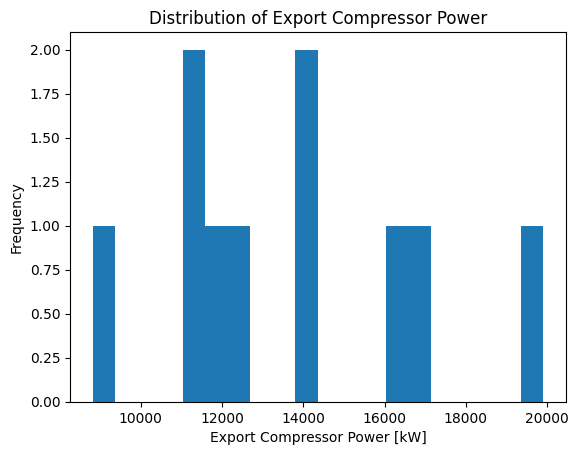

In [ ]:
# Plot the exportcompressor_power values from all the results
exportcompressor_power_list = [r.exportcompressor_power for r in results_list]
plt.hist(exportcompressor_power_list, bins=20)
plt.xlabel('Export Compressor Power [kW]')
plt.ylabel('Frequency')
plt.title('Distribution of Export Compressor Power')
plt.show()